# Getting started
-----
## Goals
- Gradient descent
- Newton's method and KKT conditions
- Regularization
- Newton approximations
- Line search
- Exercises with GRAPE 

# Unconstrained Optimization

$$ \min_{\bm x} J(\bm x) $$

### Necessary Conditions


$$ \nabla J ( \bm{x}^* ) = \bm{0} $$
$$ \nabla^2 J(\bm{x}^*) \succeq \bm{0} $$

## Gradient Descent

### Gradient Descent Update Rule

The gradient descent algorithm updates the current point \( x \) by stepping in the direction opposite the gradient:

$$ \bm{x}_{i+1} = \bm{x}_{i} - \eta \cdot \nabla J(\bm{x}_{i}) $$

where $\eta$ is the learning rate - controlling the step size.

### Example solve

We're going to apply **gradient descent** to minimize the following:

$$ h(x) = x^4 + x^3 - x^2 - x $$

This is a smooth, non-linear function with multiple stationary points. Our goal is to find a local minimum by starting from an initial value and following the gradient downhill: $\nabla h(x^*) = 0$


## Add line search

In [ ]:
function backtracking_regularized_newton_step(xᵢ)
    H = ∇²h(xᵢ)

    ## regularization
    β = 1.0
    while !isposdef(H)
        H = H + β*I
    end
    Δx = -H\∇h(xᵢ)

    ## line search
    b = 0.1
    c = 0.25
    α = 1.0
    while h(xᵢ + α*Δx) > h(xᵢ) + b*α*∇h(xᵢ)*Δx
        α = c*α
    end
    
    return xᵢ + α*Δx
end

## Initial guess
# xᵢ = 1.19
xᵢ = 0.0

## Initial plot
fig1 = Figure()
ax1 = Axis(fig1[1,1])
lines!(ax1, x, h(x))

In [ ]:
xᵢ₊₁ = backtracking_regularized_newton_step(xᵢ) 
plot!(ax1, [xᵢ], [h(xᵢ)], color=:green, marker='x', markersize=25)
xᵢ = xᵢ₊₁
fig1

In [8]:
# Plotting stuffs
using CairoMakie

In [9]:
function h(x)
    return x.^4 + x.^3 - x.^2 - x
end

function ∇h(x)
    return 4.0*x.^3 + 3.0*x.^2 - 2.0*x - 1.0
end

x = range(-1.75,1.25,1000)

## Initial guess
x₀ = 1.19
# x_0 = 0.0

1.19

In [10]:
xᵢ = x₀
# xᵢ = 0.0

gradient_descent_step(xᵢ; η=0.01) = xᵢ - η * ∇h(xᵢ)

## Initial plot
fig1 = Figure()
ax1 = Axis(fig1[1,1])
lines!(ax1, x, h(x))

Lines{Tuple{Vector{Point{2, Float64}}}}

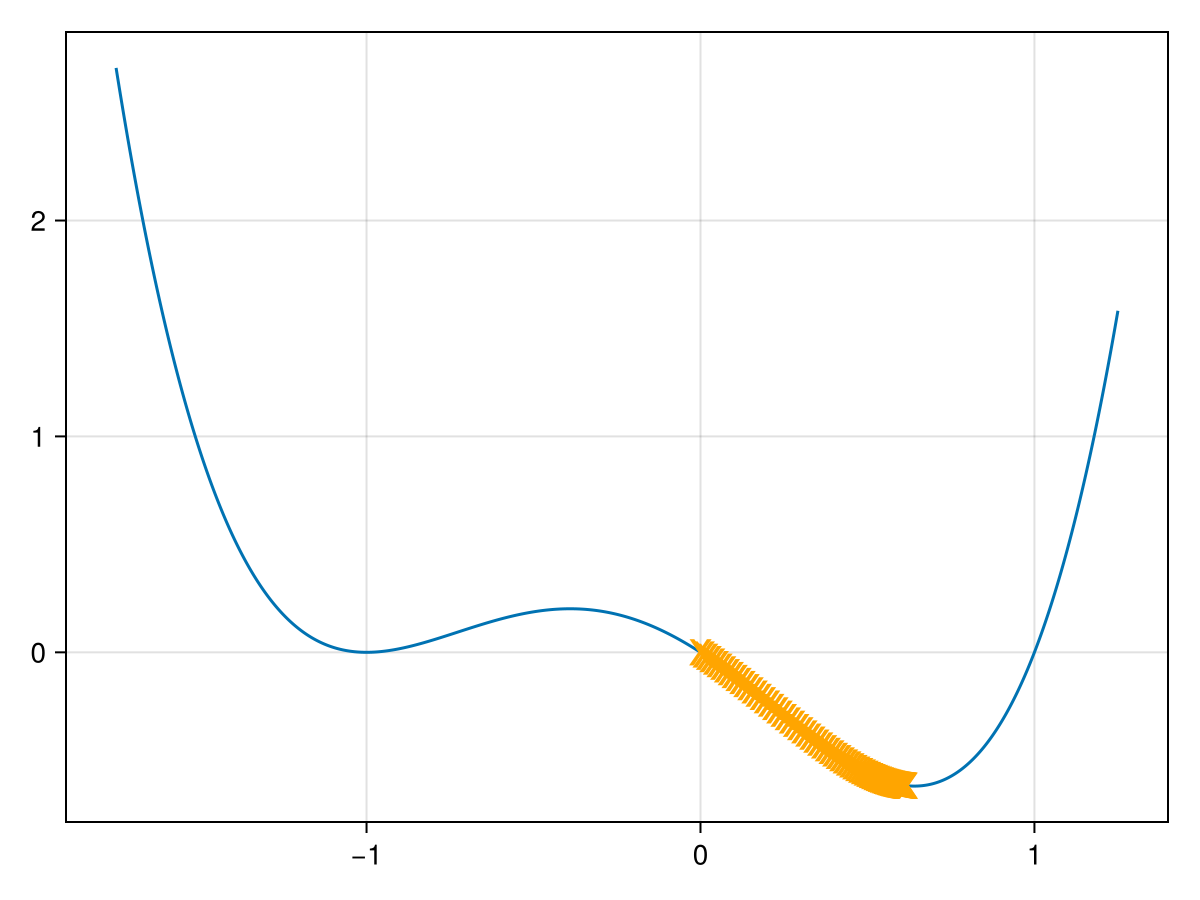

In [88]:
xᵢ₊₁ = gradient_descent_step(xᵢ, η=0.01) 
plot!(ax1, [xᵢ], [h(xᵢ)], color=:orange, marker='x', markersize=25)
xᵢ = xᵢ₊₁
fig1

## Newtons Method

Now we're using a local quadratic approximation, for a nearby guess $x_k$ the value of $J(\bm{x})$ can be well-approximated as

$$ J(\bm{x}) \approx J(\bm{x}_k) + \nabla J(\bm{x})^T (\bm{x} - \bm{x}_k) + \frac{1}{2} (\bm{x} - \bm{x}_k)^T \nabla^2 J(\bm{x}_k) (\bm{x} - \bm{x}_k)$$

And we can solve for our necessary condition

$$
\begin{align}
\bm{0} & \overset{\mathrm{!}}{=} \nabla J(\bm{x} + \Delta \bm{x}) \approx \nabla J(\bm{x}) + \nabla^2 J(\bm{x}) \Delta \bm{x} \\
\Delta \bm{x} & \overset{\mathrm{!}}{=} - \left(\nabla^2 J(\bm{x}) \right)^{-1} \nabla J(\bm{x}) \\ 
\end{align} 
$$

In [12]:
function ∇²h(x)
    return 12.0*x.^2 + 6.0*x - 2.0
end

∇²h (generic function with 1 method)

In [89]:
# xᵢ = x₀
xᵢ = 0.0
newton_step(xᵢ) = xᵢ - ∇²h(xᵢ)\∇h(xᵢ)

## Initial plot
fig1 = Figure()
ax1 = Axis(fig1[1,1])
lines!(ax1, x, h(x))


Lines{Tuple{Vector{Point{2, Float64}}}}

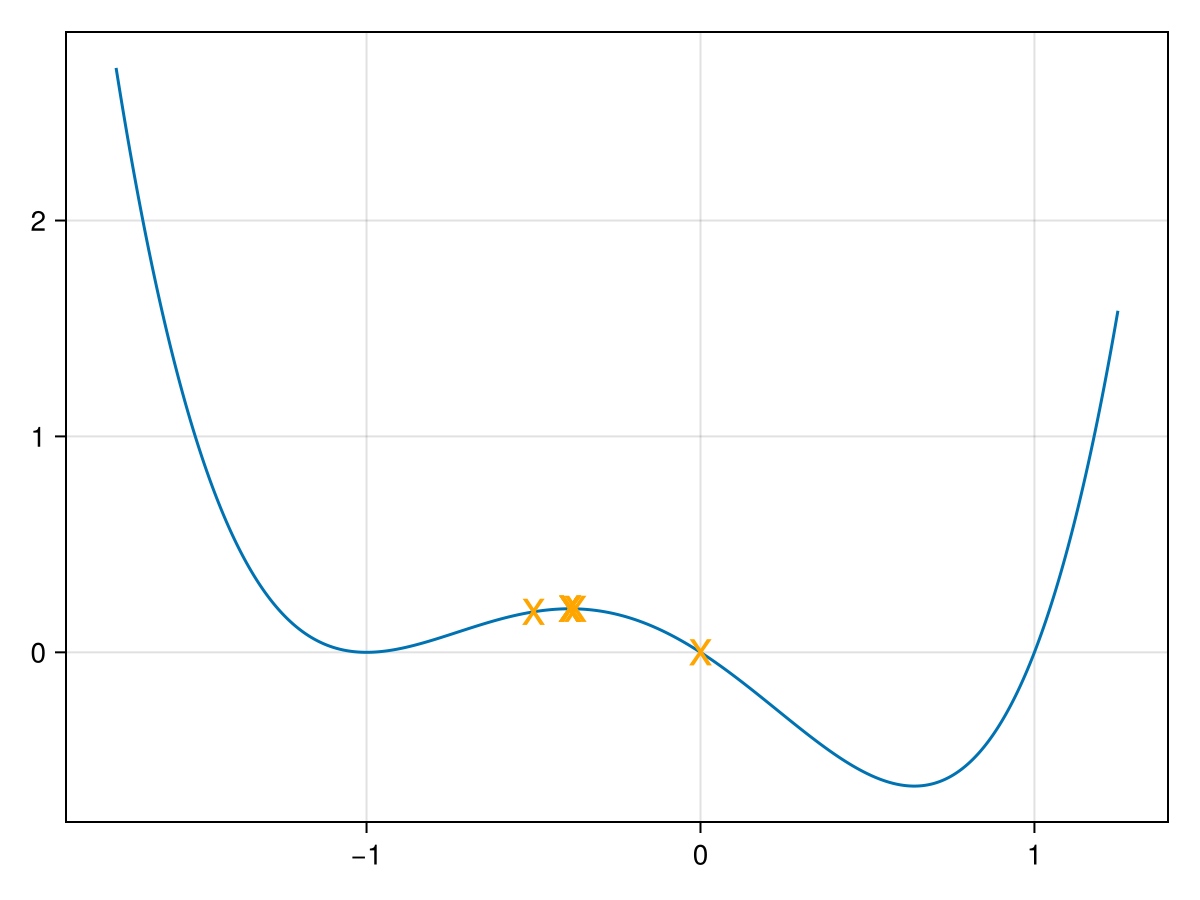

In [98]:
xᵢ₊₁ = newton_step(xᵢ) 
plot!(ax1, [xᵢ], [h(xᵢ)], color=:orange, marker='x', markersize=25)
xᵢ = xᵢ₊₁
fig1

## Add Regularization


In [ ]:
function regularized_newton_step(xᵢ)
    β = 1.0
    H = ∇²h(xᵢ)
    while !isposdef(H)
        H = H + β*I
    end
    return xᵢ - H\∇h(xᵢ)
end

## Initial guess
# xᵢ = 1.19
xᵢ = 0.0

## Initial plot
fig1 = Figure()
ax1 = Axis(fig1[1,1])
lines!(ax1, x, h(x))

In [ ]:
xᵢ₊₁ = regularized_newton_step(xᵢ) 
plot!(ax1, [xᵢ], [h(xᵢ)], color=:red, marker='x', markersize=25)
xᵢ = xᵢ₊₁
fig1

## Add line search

In [ ]:
function backtracking_regularized_newton_step(xᵢ)
    H = ∇²h(xᵢ)

    ## regularization
    β = 1.0
    while !isposdef(H)
        H = H + β*I
    end
    Δx = -H\∇h(xᵢ)

    ## line search
    b = 0.1
    c = 0.25
    α = 1.0
    while h(xᵢ + α*Δx) > h(xᵢ) + b*α*∇h(xᵢ)*Δx
        α = c*α
    end
    
    return xᵢ + α*Δx
end

## Initial guess
# xᵢ = 1.19
xᵢ = 0.0

## Initial plot
fig1 = Figure()
ax1 = Axis(fig1[1,1])
lines!(ax1, x, h(x))

In [ ]:
xᵢ₊₁ = backtracking_regularized_newton_step(xᵢ) 
plot!(ax1, [xᵢ], [h(xᵢ)], color=:green, marker='x', markersize=25)
xᵢ = xᵢ₊₁
fig1

# II. Constrained Optimization

In this section, we are going to learn about *constrained optimization*. Let's keep things simple, and try to avoid all of the regularization and line search stuff. In the next cells, we'll define a 2D bowl as our cost function, and we'll draw some nice level curves to visualize it--it's a convex cost, so we know it will have a minimum at the bottom of the bowl. To make it interesting, we will add a single constraint, which we draw as a level curve.

In [ ]:
Q = Diagonal([0.5; 1])

## Objective
function J(x)
    return 1 / 2 * (x - [1; 0])' * Q * (x - [1; 0])
end

function ∇J(x)
    return Q * (x - [1; 0])
end

function ∇²J(x)
    return Q
end

## Linear constraint -- you can try this, also.
# A = [1.0 -1.0]
# b = -1.0
# function f(x)
#     return A * x - b
# end

# function ∂f(x)
#     return A
# end

## Nonlinear constraint
function f(x)
    return x[1]^2 + 2*x[1] - x[2]
end

function ∂f(x)
    return [2*x[1]+2 -1]
end

In [ ]:
function draw_contour(ax; samples=40, levels=25)
    cols = kron(ones(samples), range(-4, 4, samples)')
    rows = kron(ones(samples)', range(-4, 4, samples))
    vals = zeros(samples,samples)
    for j = 1:samples
        for k = 1:samples
            vals[j, k] = J([cols[j, k]; rows[j, k]])
        end
    end
    contour!(ax, vec(cols), vec(rows), vec(vals), levels=levels)

    ## Linear x - y + 1 = 0 -- uncomment this if you want to try linear constraint
    # constraint = range(-4, 3, samples)
    # lines!(ax, constraint, constraint .+ 1, color=:black, linewidth=2)

    ## Nonlinear x^2 + 2x - y = 0
    constraint = range(-3.2, 1.2, samples)
    lines!(ax, constraint, constraint.^2 .+ 2*constraint, color=:black, linewidth=2)
end

In [ ]:
function newton_step(xᵢ, λᵢ)
    ∂²L_∂x² = ∇²J(xᵢ) + ForwardDiff.jacobian(x -> ∂f(x)'λᵢ, xᵢ)
    ∂f_∂x = ∂f(xᵢ)

    ## KKT system
    H = [∂²L_∂x² ∂f_∂x'; ∂f_∂x 0]
    g = [∇J(xᵢ) + ∂f_∂x'λᵢ; f(xᵢ)]
    
    Δz = -H\g
    Δx = Δz[1:2]
    Δλ = Δz[3]
    return xᵢ .+ Δx, λᵢ .+ Δλ
end

In [ ]:
fig = Figure()
ax = Axis(fig[1,1], aspect=1)

## Initial guess
# xᵢ = Float64[-0.75; -1.75]
xᵢ = Float64[-3; 2]
λᵢ = Float64[0.0]

## Draw the initial contours and the initial guess
draw_contour(ax)
plot!(ax, [xᵢ[1]], [xᵢ[2]], color=:red, marker=:circle, markersize=15)
fig

In [ ]:
xᵢ₊₁, λᵢ₊₁ = newton_step(xᵢ, λᵢ)
plot!(ax, [xᵢ₊₁[1]], [xᵢ₊₁[2]], color=:red, marker=:x, markersize=15)
xᵢ .= xᵢ₊₁
λᵢ .= λᵢ₊₁

fig

In [ ]:
## Inspect the Hessian
H = ∇²J(xᵢ) + ForwardDiff.jacobian(x -> ∂f(x)'λᵢ, xᵢ)

We need regularization... even though we picked a convex cost! The constraint in our system messed things up. Let's add regularization, but we will do so a bit differently.

Recall from Part I, where we learned about LBFGS approximation to Newton's method, and how the LBFGS seemed to have robustness properites that Newton's method lacked. We will make a similar approximation to our KKT system, called the *Gauss-Newton approximation*. See the exercises below for a more detailed explanation.

The thought process is as follows: After inspecting `∂²L_∂x² = ∇²J(xᵢ) + ForwardDiff.jacobian(x -> ∂f(x)'λᵢ, xᵢ)`, we note that $\nabla^2 J$ is convex by construction. It is just the `ForwardDiff.jacobian(x -> ∂f(x)'λᵢ, xᵢ)` that causes trouble with the Hessian. At this time, we also notice that latter term is also expensive to compute. Because it causes trouble and is costly to compute, we decide to drop this term. This is the Gauss-Newton approximation. Its steps compute faster, but converge slower than Newton--luckily, the savings in compute speed often overtake any reduction in convergence rate!

In [ ]:
function gauss_newton_step(xᵢ, λᵢ)
    ## Implicit regularization
    ∂²L_∂x² = ∇²J(xᵢ) #+ ForwardDiff.jacobian(x -> ∂f(x)'λᵢ, xᵢ)
    ∂f_∂x = ∂f(xᵢ)

    ## KKT system
    H = [∂²L_∂x² ∂f_∂x'; ∂f_∂x 0]
    g = [∇J(xᵢ) + ∂f_∂x'λᵢ; f(xᵢ)]
    
    Δz = -H\g
    Δx = Δz[1:2]
    Δλ = Δz[3]
    return xᵢ .+ Δx, λᵢ .+ Δλ
end

This quick calculation should hopefully remind you about the Gauss-Newton approximation.

Start with a cost $J(\mathbf{x})$. The necessary condition for optimality is $\nabla J(\mathbf{x}) = 0$. Our journey starts by asking what happens if $J(\mathbf{x})$ is actually a least squares problem. For example, $J(\mathbf{x}) := \frac{1}{2}||\mathbf{g}(\mathbf{x})||_2^2$. 

\begin{equation}
    \nabla J(\mathbf{x}) = \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T} \mathbf{g}(\mathbf{x})
\end{equation}

\begin{equation}
    \nabla^2 J(\mathbf{x}) = \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T} \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}} + \nabla(\frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T}) \mathbf{g}(\mathbf{x}) \approx \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T} \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}
\end{equation}

\begin{equation}
    \Delta \mathbf{x} = - \left(\frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T} \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}\right)^{-1}
    \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T} \mathbf{g}(\mathbf{x})
\end{equation}

In [ ]:
fig = Figure()
ax = Axis(fig[1,1], aspect=1)

## Initial guess
# xᵢ = Float64[-0.75; -1.75]
xᵢ = Float64[-3; 2]
λᵢ = Float64[0.0]

draw_contour(ax)
plot!(ax, [xᵢ[1]], [xᵢ[2]], color=:green, marker=:circle, markersize=15)

In [ ]:
xᵢ₊₁, λᵢ₊₁ = gauss_newton_step(xᵢ, λᵢ)
plot!(ax, [xᵢ₊₁[1]], [xᵢ₊₁[2]], color=:green, marker=:x, markersize=15)
xᵢ .= xᵢ₊₁
λᵢ .= λᵢ₊₁

fig